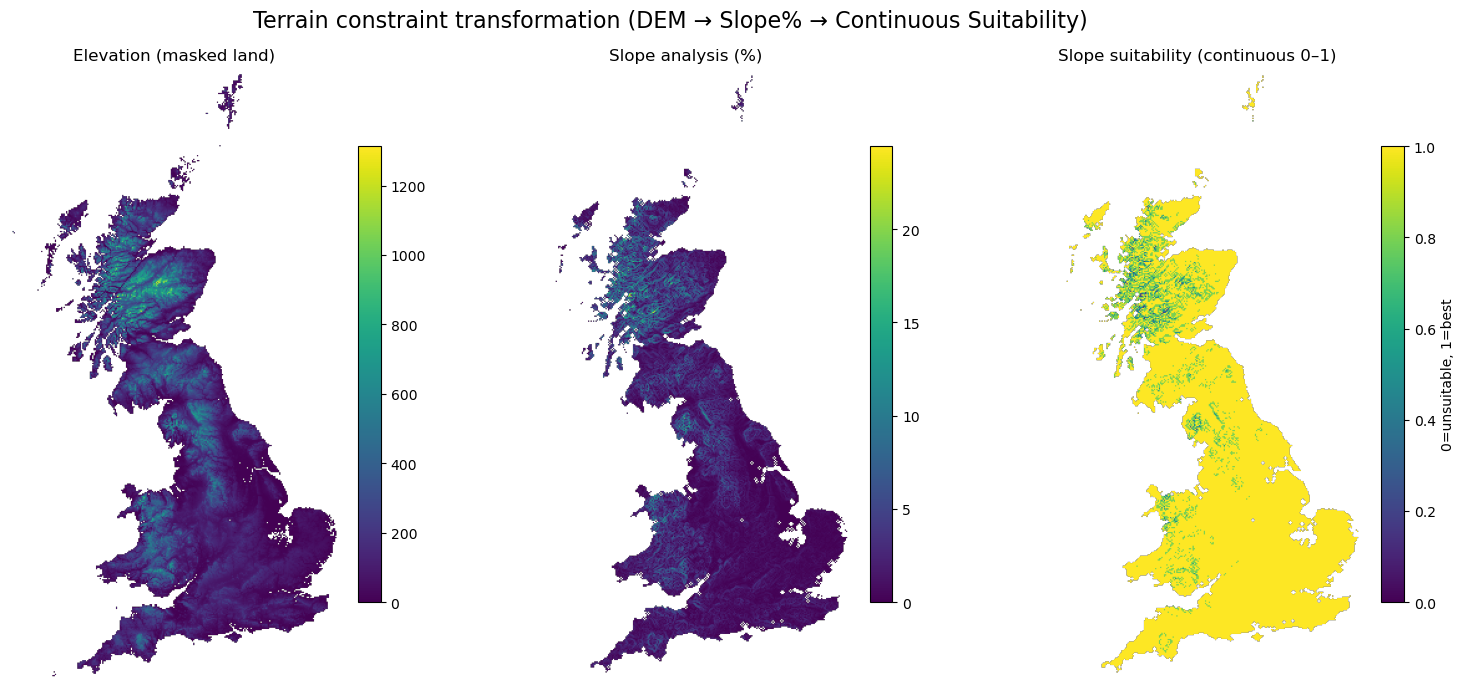


--- Land-only stats ---
Land pixels: 33,222
Share in    0–5%:  88.52%  -> score 1.0
Share in   5–10%:   9.81%  -> score 0.8
Share in  10–15%:   1.50%  -> score 0.5
Share in  15–25%:   0.17%  -> score 0.2
Share in    >25%:   0.00%  -> score 0.0

Mean slope suitability (land-only): 0.972

Saved:
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/dem_epsg27700.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/slope_percent_epsg27700.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/slope_suitability_continuous_epsg27700.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/figure_slope_triplet_continuous_epsg27700.png


In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt


DEM_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif"
OUT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_CRS = "EPSG:27700"  


SLOPE_BINS   = [0.0, 5.0, 10.0, 15.0, 25.0, np.inf]
SLOPE_SCORES = [1.0, 0.8, 0.5, 0.2, 0.0]  


def reproject_raster_to_crs(src_path, dst_path, dst_crs):
    """Reproject a single-band raster to target CRS and return array + profile."""
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        profile = src.profile.copy()
        profile.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "dtype": "float32",
            "count": 1,
            "nodata": np.nan
        })

        dst = np.full((height, width), np.nan, dtype="float32")

        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

    with rasterio.open(dst_path, "w", **profile) as out:
        out.write(dst, 1)

    return dst, profile


def compute_slope_percent(dem, transform):
    """Compute slope in percent from DEM (meters) using numpy gradient."""
    dx = transform.a          # pixel width (m)
    dy = -transform.e         # pixel height (m) (transform.e is negative)

   
    gy, gx = np.gradient(dem, dy, dx)

    slope_rad = np.arctan(np.sqrt(gx**2 + gy**2))
    slope_percent = np.tan(slope_rad) * 100.0
    return slope_percent.astype("float32")


def slope_to_suitability_continuous(slope_pct, invalid_mask,
                                   bins=SLOPE_BINS, scores=SLOPE_SCORES):
    """
    Reclass slope% into a continuous suitability index (0-1) using piecewise bins.
    invalid_mask=True -> nan in output
    """
    suit = np.full(slope_pct.shape, np.nan, dtype="float32")

    
    valid = ~invalid_mask & np.isfinite(slope_pct)

   
    idx = np.digitize(slope_pct[valid], bins, right=False) - 1
    idx = np.clip(idx, 0, len(scores) - 1)

    suit[valid] = np.array(scores, dtype="float32")[idx]
    return suit


def write_geotiff(out_path, array, profile):
    prof = profile.copy()
    prof.update({"dtype": "float32", "count": 1, "nodata": np.nan})
    with rasterio.open(out_path, "w", **prof) as dst:
        dst.write(array.astype("float32"), 1)



dem_27700_path = os.path.join(OUT_DIR, "dem_epsg27700.tif")
dem_m, dem_prof_m = reproject_raster_to_crs(DEM_PATH, dem_27700_path, TARGET_CRS)


invalid = (~np.isfinite(dem_m)) | (dem_m <= 0)
dem_m_masked = dem_m.copy()
dem_m_masked[invalid] = np.nan


slope_pct = compute_slope_percent(dem_m_masked, dem_prof_m["transform"])


suit_cont = slope_to_suitability_continuous(slope_pct, invalid)


slope_tif = os.path.join(OUT_DIR, "slope_percent_epsg27700.tif")
suit_tif  = os.path.join(OUT_DIR, "slope_suitability_continuous_epsg27700.tif")

write_geotiff(slope_tif, slope_pct, dem_prof_m)
write_geotiff(suit_tif,  suit_cont, dem_prof_m)


fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle("Terrain constraint transformation (DEM → Slope% → Continuous Suitability)", fontsize=16)


im0 = axes[0].imshow(np.ma.masked_invalid(dem_m_masked))
axes[0].set_title("Elevation (masked land)")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


im1 = axes[1].imshow(np.ma.masked_invalid(slope_pct))
axes[1].set_title("Slope analysis (%)")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)


im2 = axes[2].imshow(np.ma.masked_invalid(suit_cont), vmin=0, vmax=1)
axes[2].set_title("Slope suitability (continuous 0–1)")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="0=unsuitable, 1=best")

plt.tight_layout()
out_png = os.path.join(OUT_DIR, "figure_slope_triplet_continuous_epsg27700.png")
plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()


land = ~invalid & np.isfinite(slope_pct)

print("\n--- Land-only stats ---")
print(f"Land pixels: {land.sum():,}")


labels = ["0–5%", "5–10%", "10–15%", "15–25%", ">25%"]
for i in range(len(SLOPE_SCORES)):
    lo = SLOPE_BINS[i]
    hi = SLOPE_BINS[i+1]
    if np.isinf(hi):
        mask = land & (slope_pct >= lo)
    else:
        mask = land & (slope_pct >= lo) & (slope_pct < hi)
    pct = mask.sum() / land.sum() * 100.0
    print(f"Share in {labels[i]:>7}: {pct:6.2f}%  -> score {SLOPE_SCORES[i]}")

mean_suit = np.nanmean(suit_cont)
print(f"\nMean slope suitability (land-only): {mean_suit:.3f}")

print("\nSaved:")
print(" -", dem_27700_path)
print(" -", slope_tif)
print(" -", suit_tif)
print(" -", out_png)
